In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
%matplotlib inline
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf

from src.helpers import (get_rankings_table, get_goal_difference_table,
                    get_max_probas_table,  get_confs_table, simulate_match)
data =  pd.read_csv('../intermediate/training_data.csv')
data = data[['SeasonID', 'MatchID', 'HomeTeamID', 'AwayTeamID', 'HomeTeamName','AwayTeamName',
       'HomeScore', 'HomeShots', 'AwayScore', 'AwayShots', 'HomeYield',
       'AwayYield', 'NetHomeGoals', 'AbsGd', 'Sin_GW', 'Cos_GW',
       'HomeOverallRank', 'AwayOverallRank', 'result']].set_index('MatchID')
# data = data[data.SeasonID == 1]

In [7]:
%matplotlib notebook

In [8]:
%matplotlib inline

In [9]:
data.columns

Index(['SeasonID', 'HomeTeamID', 'AwayTeamID', 'HomeTeamName', 'AwayTeamName',
       'HomeScore', 'HomeShots', 'AwayScore', 'AwayShots', 'HomeYield',
       'AwayYield', 'NetHomeGoals', 'AbsGd', 'Sin_GW', 'Cos_GW',
       'HomeOverallRank', 'AwayOverallRank', 'result'],
      dtype='object')

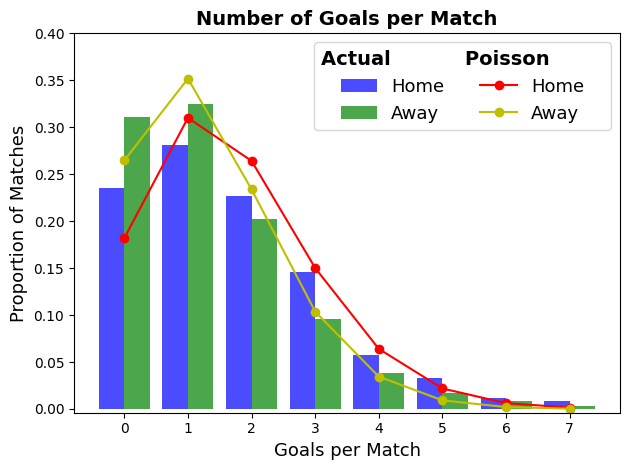

In [10]:
# construct Poisson for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, data[['HomeScore', 'AwayScore']].mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(data[['HomeScore', 'AwayScore']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],density=True, color=["b", "g"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'y')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Actual           Poisson        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.savefig('../plots/poisson.png')
plt.show()


In [11]:
# probability of draw between home and away team
skellam.pmf(0.0,  data.mean()[0],  data.mean()[1])

0.00016761869759826092

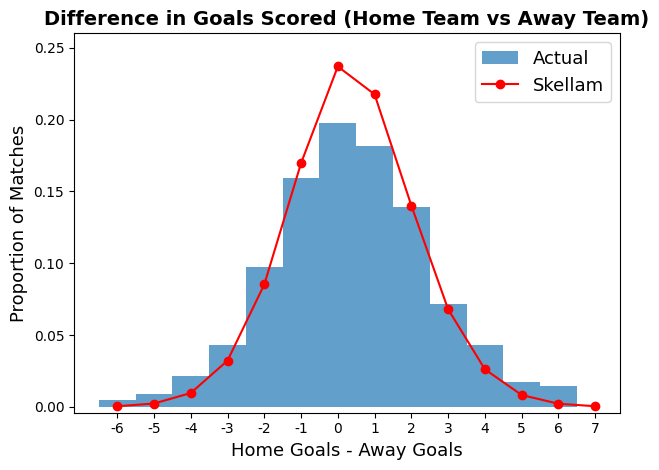

In [12]:
skellam_pred = [skellam.pmf(i,  data[['HomeScore', 'AwayScore']].mean()[0],  data[['HomeScore', 'AwayScore']].mean()[1]) for i in range(-6,8)]

plt.hist(data[['HomeScore']].values - data[['AwayScore']].values, range(-6,8), 
         alpha=0.7, label='Actual',density=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = 'r')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.savefig('../plots/skella.png')
plt.show()

In [13]:
goal_model_data = pd.concat([data[['HomeTeamName','AwayTeamName','HomeScore']].assign(home=1).rename(
            columns={'HomeTeamName':'team', 'AwayTeamName':'opponent','HomeScore':'goals'}),
           data[['AwayTeamName','HomeTeamName','AwayScore']].assign(home=0).rename(
            columns={'AwayTeamName':'team', 'HomeTeamName':'opponent','AwayScore':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 3024
Model:                            GLM   Df Residuals:                     2968
Model Family:                 Poisson   Df Model:                           55
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4444.4
Date:                Thu, 03 Aug 2023   Deviance:                       3352.7
Time:                        14:44:49   Pearson chi2:                 2.97e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2995
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3088      0.117      2.629      0.009       0.079       0.539
team[T.Arlington]                0.4482      0.123      3.638      0.000       0.207       0.690
team[T.Atlanta]                  0.1543      0.132      1.173      0.241      -0.104       0.412
team[T.Baltimore]                0.7491      0.117      6.419      0.000       0.520       0.978
team[T.Boston]                   0.7879      0.116      6.786      0.000       0.560       1.015
team[T.Chicago B]                0.6470      0.119      5.448      0.000       0.414       0.880
team[T.Chicago H]                0.5654      0.121      4.688      0.000       0.329       0.802
team[T.Cincinnati]               0.8149      0.116      7.050      0.000       0.588       1.042
team[T.Cleveland Queens]         0.0360      0.135      0.267      0.790      -0.229       0.301
team[T.Denver]                  -0.1631      0.143     -1.143      0.253      -0.443       0.117
team[T.Detroit]                  0.4322      0.124      3.492      0.000       0.190       0.675
team[T.Houston]                  0.0525      0.135      0.390      0.697      -0.211       0.317
team[T.Kansas City]              0.3743      0.125      2.991      0.003       0.129       0.620
team[T.Los Angeles]              0.0839      0.134      0.628      0.530      -0.178       0.346
team[T.Miami]                    1.0347      0.112      9.233      0.000       0.815       1.254
team[T.Milwaukee]                0.0405      0.135      0.299      0.765      -0.225       0.306
team[T.Minneapolis]              0.4735      0.123      3.860      0.000       0.233       0.714
team[T.Montreal]                 0.1683      0.131      1.284      0.199      -0.089       0.425
team[T.New York C]              -0.1270      0.141     -0.898      0.369      -0.404       0.150
team[T.New York S]               0.6813      0.118      5.772      0.000       0.450       0.913
team[T.Oakland]                  0.4498      0.123      3.651      0.000       0.208       0.691
team[T.Philadelphia]             0.3818      0.125      3.059      0.002       0.137       0.626
team[T.Pittsburgh]               0.3802      0.125      3.039      0.002       0.135       0.625
team[T.San Diego]               -0.1445      0.142     -1.019      0.308      -0.423       0.134
team[T.San Francisco]           -0.1592      0.142     -1.119      0.263      -0.438       0.120
team[T.Seattle]                  0.6883      0.118      5.836      0.000       0.457       0.919
team[T.St. Louis]                0.6254      0.119      5.245      0.000       0.392       0.859
team[T.Toronto]                  0.2566      0.128      2.003      0.045       0.006       0.508
opponent[T.Arlington]           -0.6181      0.107     -5.800      0.000    

In [14]:
goal_model_data

,team,opponent,goals,home
MatchID,,,,
1,Chicago H,Arlington,1,1
2,Chicago B,Cincinnati,1,1
3,Boston,Cleveland Queens,5,1
4,Baltimore,Denver,2,1
5,Atlanta,Detroit,3,1
...,...,...,...,...
1508,New York S,Denver,6,0
1509,Montreal,Detroit,2,0
1510,Minneapolis,Houston,3,0


In [15]:
goals = poisson_model.get_prediction(pd.DataFrame(data={'team': 'Toronto', 'opponent': 'St. Louis',
                                       'home':1},index=[1]))
goals.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,1.089325,0.134854,0.854638,1.388458


In [16]:
simulate_match(poisson_model, 'Anaheim', 'Arlington',  max_goals=3)

(7.019140226333703, 5.099831968976583, 2.0788824373597694, 1.1909968384008485)

In [17]:
odds = pd.read_csv('../data/odds.csv')
fixtures = pd.read_csv('../data/fixtures.csv')
teams = pd.read_csv('../data/teams.csv')
teams_dict = pd.Series(teams.TeamName.values,index=teams.TeamID).to_dict()
test = odds.merge(fixtures, on='MatchID')
test['HomeTeamName'] = test['HomeTeamID']
test['HomeTeamName'] = test['HomeTeamName'].map(teams_dict).fillna(test['HomeTeamName'])
test['AwayTeamName'] = test['AwayTeamID']
test['AwayTeamName'] = test['AwayTeamName'].map(teams_dict).fillna(test['AwayTeamName'])
PoissonOdds = test.apply(lambda x: simulate_match(poisson_model, x['HomeTeamName'], x['AwayTeamName'],  max_goals=3), axis=1)
PoissonOdds = PoissonOdds.apply(pd.Series)
PoissonOdds.columns=['PoissonHomeOdds','PoissonDrawOdds', 'PoissonAwayOdds', 'PoissonNetHomeGoals']
out = test.merge(PoissonOdds, left_index=True, right_index=True)
out['HomeOddsDifference'] = out['PoissonHomeOdds'] - out['Home']
out['DrawOddsDifference'] = out['PoissonDrawOdds'] - out['Draw']
out['AwayOddsDifference'] = out['PoissonAwayOdds'] - out['Away']

In [18]:
cols = ['MatchID', 'HomeTeamName', 'AwayTeamName', 'Home', 'Draw', 'Away','PoissonHomeOdds',
       'PoissonDrawOdds', 'PoissonAwayOdds', 'HomeOddsDifference', 'PoissonNetHomeGoals',
       'DrawOddsDifference', 'AwayOddsDifference']

In [19]:
out[cols].sort_values(by=['HomeOddsDifference', 'DrawOddsDifference', 'AwayOddsDifference'], ascending=False)

,MatchID,HomeTeamName,AwayTeamName,Home,Draw,Away,PoissonHomeOdds,PoissonDrawOdds,PoissonAwayOdds,HomeOddsDifference,PoissonNetHomeGoals,DrawOddsDifference,AwayOddsDifference
495,1252,San Diego,Miami,13.16,6.94,1.23,46.003832,15.668304,2.274549,32.843832,3.063699,8.728304,1.044549
301,1058,Anaheim,Miami,17.38,9.17,1.16,48.169354,17.661346,2.575804,30.789354,3.271488,8.491346,1.415804
585,1342,Denver,Miami,34.88,14.79,1.07,56.125182,18.400175,2.444009,21.245182,3.281728,3.610175,1.374009
13,770,Milwaukee,Miami,13.29,7.83,1.21,34.519391,13.622868,2.298984,21.229391,2.904795,5.792868,1.088984
81,838,New York C,Miami,47.34,17.01,1.05,65.613955,21.501750,2.698236,18.273955,3.507777,4.491750,1.648236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,1011,Houston,Cincinnati,17.66,8.64,1.17,11.621154,6.531156,1.948898,-6.038846,1.743404,-2.108844,0.778898
262,1019,New York C,Seattle,23.73,10.23,1.12,17.418828,8.343738,1.981606,-6.311172,2.166430,-1.886262,0.861606
512,1269,San Francisco,Miami,46.52,16.75,1.05,37.852158,13.141146,2.089477,-8.667842,2.814093,-3.608854,1.039477
523,1280,Denver,Seattle,25.30,13.50,1.09,15.876530,7.596708,1.902441,-9.423470,2.017716,-5.903292,0.812441


In [20]:
out['PredWinner'] = out[['PoissonHomeOdds', 'PoissonDrawOdds', 'PoissonAwayOdds']].idxmax(axis=1).str.replace('Poisson', '', regex=True).str.replace('Odds', '', regex=True)
def result(x):
    if x == 'Home': return 1
    elif x == 'Away': return -1
    else: return 0
out['PredResults'] = out.PredWinner.apply(lambda x:result(x))
out['SeasonID'] = 3

Text(0.5, 0, 'Probability of game predictions')

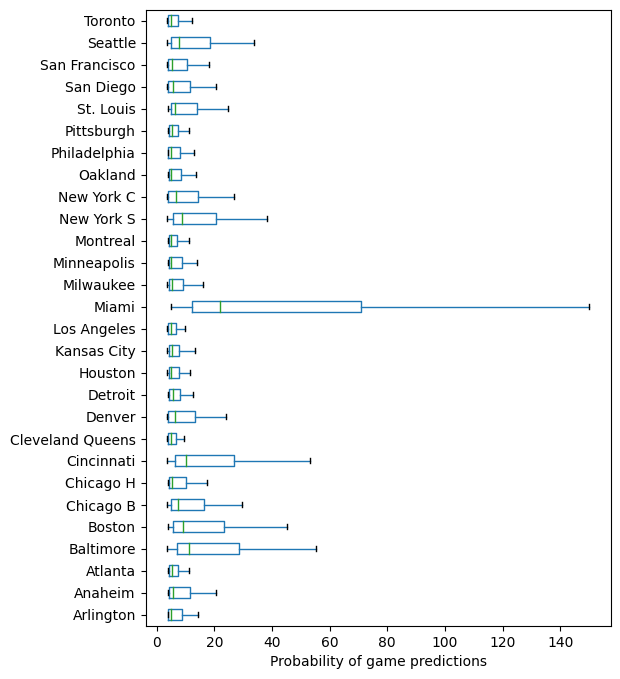

In [21]:
max_probas = get_max_probas_table(out, season=3)
max_probas = max_probas.rename(columns=teams_dict)
ax = max_probas[max_probas!=0].boxplot(vert=False, grid = False, showfliers=False, figsize=(6,8))
ax.set_xlabel("Probability of game predictions")

In [22]:
    
gds = get_goal_difference_table(out, season=3, home_gd_column='PoissonNetHomeGoals')
gds = gds.rename(columns=teams_dict)
rankings = get_rankings_table(out, result_column='PredResults', season=3)
rankings = rankings.rename(columns=teams_dict)
idx = rankings.tail(1).index.item()
rankings = rankings.sort_values(by=idx, axis=1, ascending=False)
winner = rankings.tail(1).T.head(1).index.item()


In [23]:
idx = rankings.tail(1).index.item()
all_rankings = rankings.tail(1).T.rename(columns={idx:'TotalPoints'}).merge(gds.tail(1).T.round().rename(columns={idx:'GoalDifference'}), left_index=True, right_index=True)
all_rankings = all_rankings.sort_values(by=['TotalPoints', 'GoalDifference'], ascending=False).reset_index()
all_rankings = all_rankings.rename_axis(None, axis = 1).rename(columns={'index':'Team'})
all_rankings.index.names = ['Position']
all_rankings.index += 1 
display(all_rankings)

,Team,TotalPoints,GoalDifference
Position,,,
1,New York C,64,86.0
2,Denver,64,79.0
3,San Diego,64,71.0
4,San Francisco,64,63.0
5,Anaheim,63,74.0
6,Milwaukee,59,60.0
7,Houston,58,46.0
8,Atlanta,58,44.0
9,Los Angeles,57,37.0


In [24]:
all_rankings.columns

Index(['Team', 'TotalPoints', 'GoalDifference'], dtype='object')

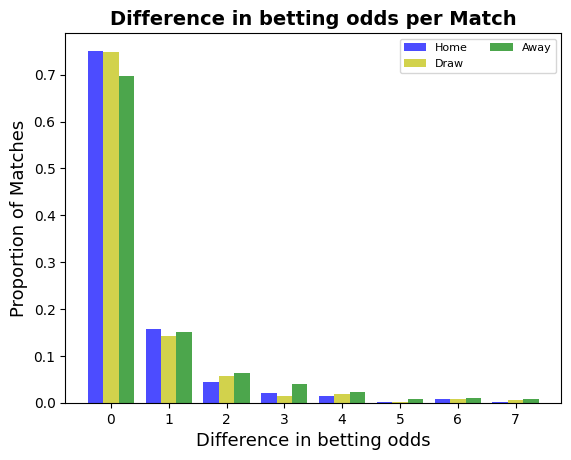

In [25]:
plt.hist(out[['HomeOddsDifference', 'DrawOddsDifference', 'AwayOddsDifference']].values, range(9), 
         alpha=0.7, label=['Home', 'Draw', 'Away'],density=True, color=["b", "y", "g"])
leg=plt.legend(loc='upper right', fontsize=8, ncol=2)

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Difference in betting odds",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in betting odds per Match",size=14,fontweight='bold')
plt.show()